<a href="https://colab.research.google.com/github/federicotarozzi/Corso_AnalistaProgrammatoreDatiGeoSpaziali/blob/main/LST_landsurfacetemperature_codice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='../img/banner.png' align='right' width='100%'></img>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<div class="alert alert-block alert-success">
<b>PREREQUISITE </b>

* It is expected for user to be familiar with Python.
* LSA SAF **MLST** product data for 21 August 2023 at 12:00 needs to be downloaded from [LSA SAF Data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/)
   
</div>

In [3]:
%pip install cartopy
%pip install colormaps
%pip install rioxarray
%pip install netcdf4
%pip install wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.9/727.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=3e68ea2538fd31aa915a02b0ef2f523e7450d40862d5205221c36a0b42e84542
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


<hr>

# Displaying LSA SAF MLST with `cartopy` and `xarray`


#### About

In this notebook, a simple example of opening and plotting the LSA SAF Meteosat Land Surface Temperature ([MLST](https://lsa-saf.eumetsat.int/en/data/products/land-surface-temperature-and-emissivity/)) product with `python` is presented. The LSA SAF products are available as NetCDF4 files. MLST is a LSA SAF product that estimates Land Surface Temperature (LST) based on measurements with the Spinning Enhanced Visible and InfraRed Imager (SEVIRI) on board of Meteosat second generation (MSG) satellite. The spatial resolution of SEVIRI measurements is 3 $\times$ 3 km directly under the satellite, while it increases towards the edge of the Earth disk.

Estimates of MLST are calculated using top of atmosphere (TOA) brightness temperature at 10.8 $\mu m$ and 12.0 $\mu m$ bands. The methodology is based on a generalized split-window (GSW) algorithm. A detailed description is available [here](https://doi.org/10.1029/2008JD010035). The MLST product is only available over land and not over the waters.

#### Basic facts on LST data

 > **Spatial resolution**: 3km at nadir
 >
 > **Spatial coverage**: MSG and IODC disk
 >
 > **Time steps**: 15 min  
 >
 > **Data availability**: from 2005
 >

#### <a id='wget'></a> How to access the data

For this example, MLST measurements from August 21, 2023, at 12:00 UTC are used. All measurements are available as NetCDF4 as well as HDF5 files, but only the former will be used here. The LSA SAF products files can be downloaded from the [data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/) available at https://datalsasaf.lsasvcs.ipma.pt/ with prior registration.

Data can be downloaded in various ways [tutorial](https://lsa-saf.eumetsat.int/en/user-support/tutorials/), for instance manually, using approach published on [lsasaf_data_access GitLab](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/blob/main/examples/webdav/webdav_colab_example.ipynb) repository or using [WebDAV protocol](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/data/webdav). An additional option is to use the `GNU Wget` program. An example command is presented:

```bash
wget -m -np -nH https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/MLST/NETCDF/2023/08/21/NETCDF4_LSASAF_MSG_LST_MSG-Disk_202308211200.nc
--user=<USERNEAME> --password=<PASSWORD> --cut-dirs=7
```

`<USERNAME>` and `<PASSWORD>` need to be replaced with the credentials obtained in the registration process described above. In this notebook, it is assumed that the required file `NETCDF4_LSASAF_MSG_LST_MSG-Disk_202308211200.nc` is already available locally in the same directory as this notebook.

#### Module outline:
* [1 - Plotting the LSA SAF MLST with cartopy and xarray](#First)
* [2 - Plotting in various map projections](#Second)


<hr>

#### Load required libraries

We start by importing the necessary libraries. Furthermore, we can set the default plot size using `plt.rcParams['figure.figuresize']` to obtain larger visible plots. The `%matplotlib inline` magic command is Jupyter-specific and used to show plots directly within the notebook interface.

In [4]:
import xarray as xr                     # a library for handling labelled, multidimensional datasetst (NetCDF4 files)
import cartopy.crs as ccrs              # a library for cartographic projections and mapping
import matplotlib.pyplot as plt         # a library for creating plots and visualizations

# Set the matplotlib backend to inline
%matplotlib inline

# Set the default figure size
plt.rcParams['figure.figsize'] = [13, 8]

### <a id='First'></a>1. Plotting LSA SAF MLST with `cartopy` and `xarray`

One of the main objects within the `xarray` library is the  `xarray.Dataset`; it is a multidimensional self-describing array database in memory. It consists of variables, coordinates and attributes. We first want to load our data and look at the file structure.

MLST data is stored in a file as a function of longitude, latitude and time. In each NetCDF4 file, there is a snapshot at a certain time. We can merge multiple of them into one dataset and therefore obtain 3D data. For each point in this coordinate system, we have measured LST, quality flag and corresponding standard errors.

NetCDF file also includes attributes, which describe how (instrumentation and calculation details) and when the file was produced. There is a distinction between `time` and `date_created` attributes, since the `time` represents the beginning of the 15-minute observing period of MSG, while `date_created` represents when the netCDF file was produced. We can define `dataset` with the following command:

In [6]:
ds=xr.load_dataset("/esercitaz/NETCDF4_LSASAF_MSG_LST_MSG-Disk_202308211200.nc")
print(ds)

<xarray.Dataset>
Dimensions:         (time: 1, lat: 3201, lon: 3201)
Coordinates:
  * lat             (lat) float32 80.0 79.95 79.9 79.85 ... -79.9 -79.95 -80.0
  * lon             (lon) float32 -80.0 -79.95 -79.9 -79.85 ... 79.9 79.95 80.0
  * time            (time) datetime64[ns] 2023-08-21T12:00:00
Data variables:
    LST             (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    crs             |S1 b''
    delta_LST0_KHS  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    quality_flag    (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    standard_error  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/29)
    date_created:               2023-08-21T12:17:47Z
    algorithm_version:          2.0.0
    base_algorithm_version:     8.0.2
    processing_level:           02
    platform:                   MSG3
    sensor:                     SEVI
    ...                         ...
    geospatial_lat_units:       deg

Sub-datasets can be produced by calling only one data variable, in this case, LST.  LST measurements are chosen during the first (and in this case the only) time interval (`.isel(time=0)`). One can also take a look at the dataset by plotting it. The quickest way to plot the `xarray.Dataset` is the built-in function, which gives clear insight into the data.

LST is calculated only for pixels, for which it was determined, i.e., they were not cloud-masked and measurements were good enough to produce reliable estimates.

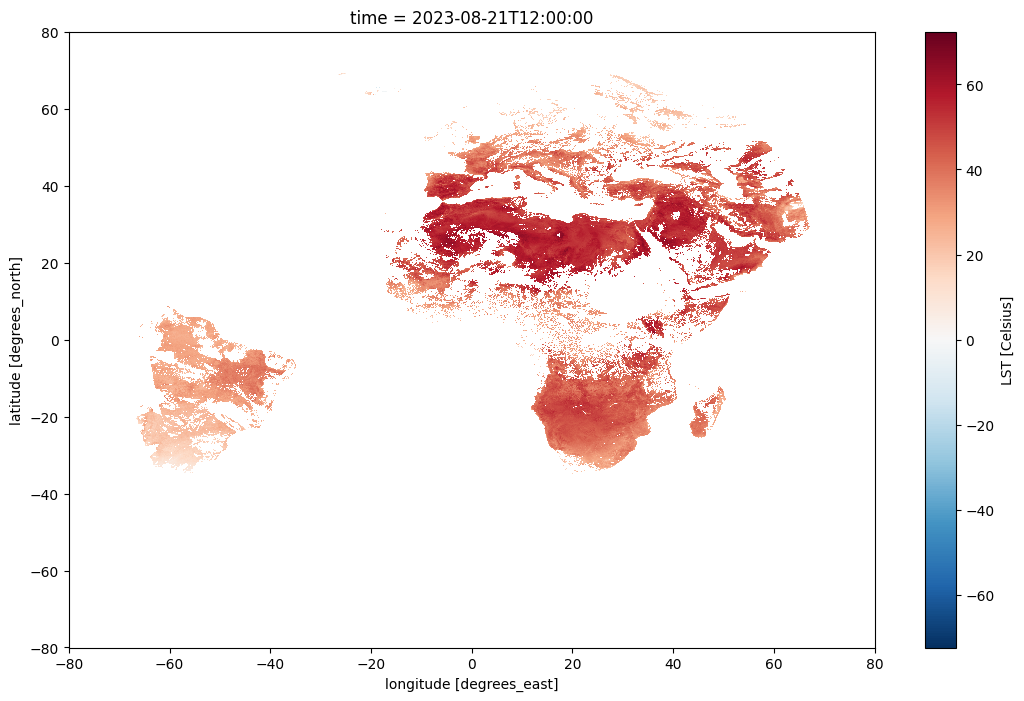

In [10]:
temp=ds.LST.isel(time=0) # ISTANTE TEMPORALE SCELTO, in questo caso è 1 solo quindi prendiamo =0
temp.plot() # forma del dato LST origniale

### <a id='Second'></a>2. Plotting in various map projections

The built-in plot function is useful to check the data, but for more advanced data visualization, additional steps need to be taken.

For additional appearance customization one can use `matplotlib.pyplot`. The `figure` and `axes` attributes first need to be determined, and then the `xarray` wrapper around `matplotlib` can be used to plot the data, while the plot appearance can be manipulated using the standard `pyplot` approach.

Plots in various projections can be achieved by virtue of the `python` module `cartopy`. Map projection can be passed as an argument into the `xarray.Dataset.plot()` wrapper. Additional features from `cartopy` such as coastlines, borders and rivers can be also added.

 When the `xarray.Dataset` is plotted using the built-in function the colorbar is automatically shown. It can also be added manually later to keep more control over its position and appearance.

Text(0.5, 1.0, 'Land Surface Temperature')

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


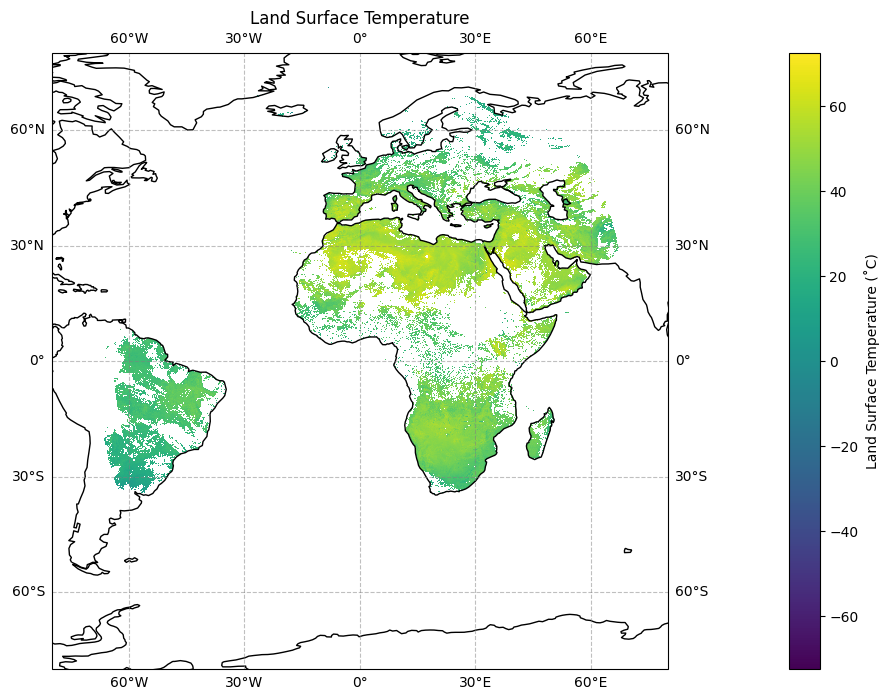

In [8]:
# Define plot projection
choosen_projection=ccrs.PlateCarree()

# Set fig, axes
fig, ax = plt.subplots(subplot_kw={'projection': choosen_projection})

# Plot the data
img = temp.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                           cmap="viridis", add_colorbar=False)

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True, linestyle='--',
             color='gray', alpha=0.5)

# Add colorbar
cbar = plt.colorbar(img, ax=ax, orientation='vertical',
                    pad=0.12, label="Land Surface Temperature (˚C)")

# Add title
plt.title("Land Surface Temperature")

# Figure can be saved with (uncomment)
#plt.savefig("../img/lst_platecarree.png)

The data are defined in the lon/lat system (in degrees) corresponding to Plate Carrée projection. They can be transformed into another map projection.

In order to do so, the desired projection needs to be passed as a subplot parameter (`subplot_kw={'projection': chosen_projection}`), while the projection in which the data was defined needs to be passed as the `transform` argument in `plot` wrapper. In the case of LST data that means `transform=ccrs.PlateCarree()`.

The plot can be also shown in other map projections, for instance, Robinson.

The area shown in the graph is automatically adapted to the available data but it can be manually adapted to the needs by `ax.set_extent()`.

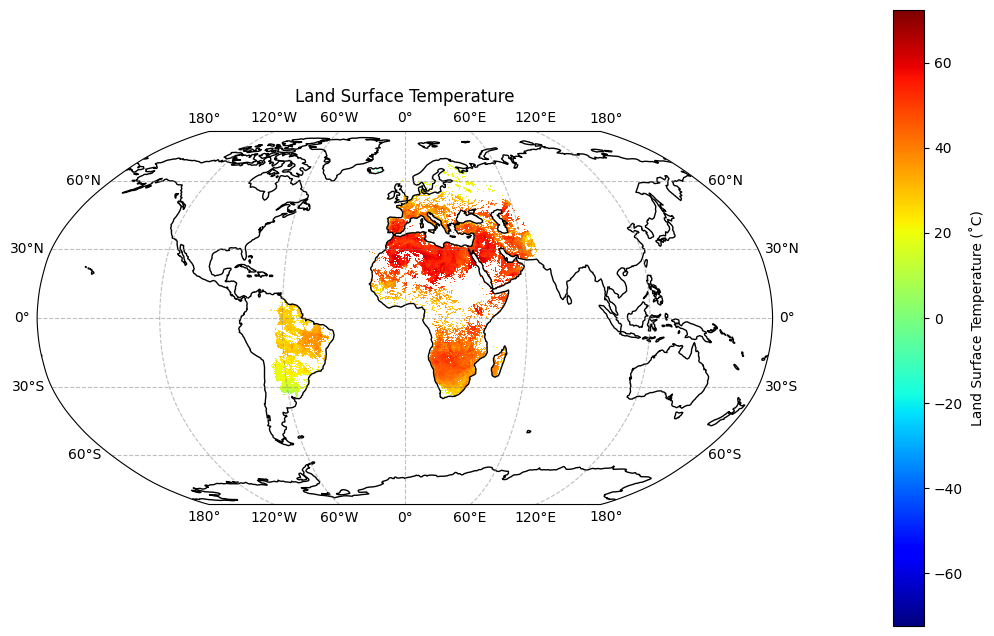

In [9]:
# Define plot projection
choosen_projection=ccrs.Robinson()

# Set fig, axes
fig, ax = plt.subplots(subplot_kw={'projection': choosen_projection})

# Plot the data
# transform = PlateCaree, although we plot in Robinson,
# since data is defined in PlateCaree
img = temp.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                           cmap="jet", add_colorbar=False)

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True, linestyle='--',
             color='gray', alpha=0.5)

# Add colorbar
cbar = plt.colorbar(img, ax=ax, orientation='vertical',
                    pad=0.12, label="Land Surface Temperature (˚C)")

# Add title
plt.title("Land Surface Temperature")

# Set extent
ax.set_extent([-179.999,179.999,-90, 90], crs=ccrs.PlateCarree())

# Figure can be saved with (uncomment)
#plt.savefig("../img/lst_robinson.png)

A full list of available projections, together with required parameters is published in the [cartopy documentation](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html#lambertconformal). Some useful projections are shown in the next figure.

The MLST product is based on measurements from two satellites: the first is centered near Greenwich (labelled MSG) and the second is centered above the Indian Ocean, approximately 41.5˚E (labelled MSG-IODC). MSG satellites observe zenith angles from 0° to 80˚, the observed area is shown by colored circles.

<img src='../img/Projections_satelite_coverage_3.png' align='center' width='60%'></img>


Presented projections here are defined in the `cartopy.crs` package:
* `PlateCaree()` lon/lat projection in which the data are defined,
* `Robinson()` not equal-area and not conformal, used for "esthetic" world maps,
* `Mollweide()` pseudocylindrical, equal area, used for world maps,
* `Sinusoidal()` equal area, common projection for polar-orbiting satellites data,
*  `LambertConformal()` is best for conformal showing small-scale maps, commonly used in navigation,
* `Geostationary()` projection of Earth as seen by geostationary satellite.

In [19]:

# QUESTA  PARTE DI CODICE SERVE PER RITAGLIARE DA UNO SHAPE FILE

import rioxarray
import geopandas
from shapely.geometry import mapping

ds.rio.set_spatial_dims(x_dim="lon", y_dim= "lat", inplace = True) # metto lat e lon perchè è il nome della variabile nel dataset precedetemente caricato
ds.rio.write_crs("epsg:4326", inplace = True)

Geometry_Shape = geopandas.read_file("/esercitaz/gadm36_ITA_0.shp", crs = "epsg:4326")
clipped_ds = ds.rio.clip(Geometry_Shape.geometry.apply(mapping), Geometry_Shape.crs, drop=True,invert=False)

clipped_ds

<xarray.Dataset>
Dimensions:         (lat: 232, lon: 238, time: 1)
Coordinates:
  * lat             (lat) float32 47.05 47.0 46.95 46.9 ... 35.6 35.55 35.5
  * lon             (lon) float32 6.65 6.7 6.75 6.8 ... 18.35 18.4 18.45 18.5
  * time            (time) datetime64[ns] 2023-08-21T12:00:00
    spatial_ref     int64 0
    crs             int64 0
Data variables:
    LST             (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    delta_LST0_KHS  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    quality_flag    (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    standard_error  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/29)
    date_created:               2023-08-21T12:17:47Z
    algorithm_version:          2.0.0
    base_algorithm_version:     8.0.2
    processing_level:           02
    platform:                   MSG3
    sensor:                     SEVI
    ...                         ...
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    keywords:                   Earth Science, Land Surface, Land Temperature...
    keywords_vocabulary:        NASA Global change Master Directory (GCMD Sci...
    Conventions:                CF-1.6
    netcdf_version_id:          netCDF4

In [21]:
clipped_italia = clipped_ds.LST
clipped_italia
#clipped_italia = clipped_ds["LST"]

<xarray.DataArray 'LST' (time: 1, lat: 232, lon: 238)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat          (lat) float32 47.05 47.0 46.95 46.9 ... 35.65 35.6 35.55 35.5
  * lon          (lon) float32 6.65 6.7 6.75 6.8 6.85 ... 18.35 18.4 18.45 18.5
  * time         (time) datetime64[ns] 2023-08-21T12:00:00
    spatial_ref  int64 0
    crs          int64 0
Attributes:
    long_name:  LST
    units:      Celsius
    valid_min:  -8000
    valid_max:  7000

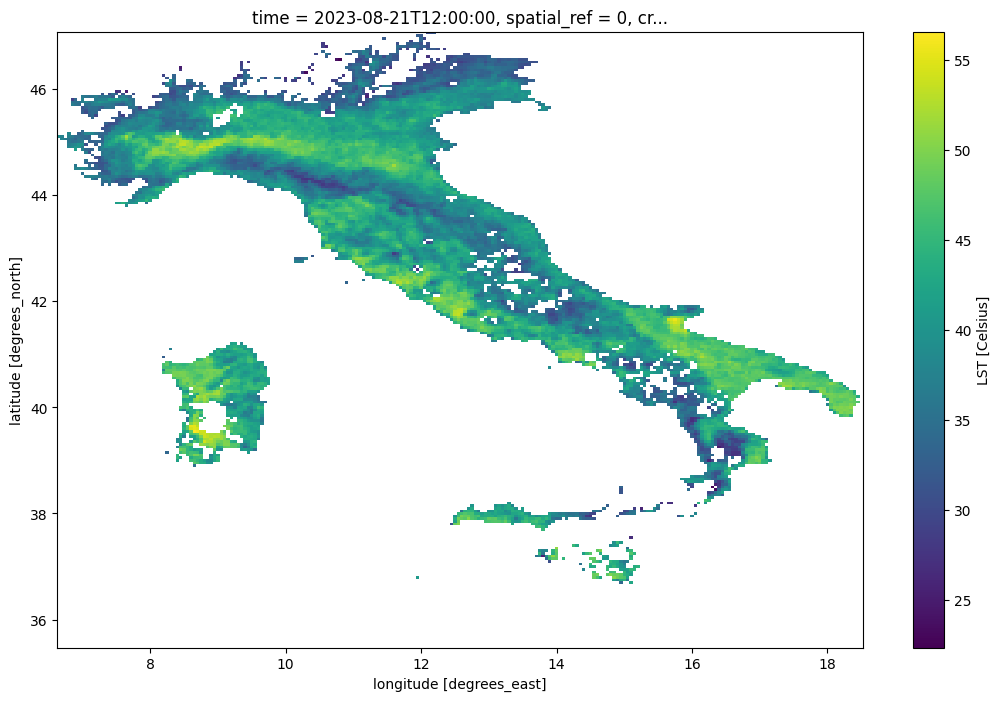

In [22]:
clipped_italia.plot()

### References:

* array Developers (2023). xarray User Guide. [https://docs.xarray.dev/en/stable/user-guide/index.html](https://docs.xarray.dev/en/stable/user-guide/index.html). Accessed: 20.11.2023.
* Met Office (2010-2015). Cartopy: a cartographic python library with a Matplotlib interface. [https://scitools.org.uk/cartopy](https://scitools.org.uk/cartopy). Accessed: 20.11.2023.
* Trigo, I. F., I. T. Monteiro, F. Olesen, and E. Kabsch (2008). An assessment of remotely sensed land surface temperature, J. Geophys. Res.,113, D17108, [doi:10.1029/2008JD010035](https://doi.org/10.1029/2008JD010035).
* Some code was adapted from:  
    * origin: [https://stackoverflow.com/a/40666180](https://stackoverflow.com/a/40666180)
    * license: CC BY-SA 3.0
    * copyright:  Stack Exchange Inc.
    * retrieved: 20.11.2023.